In [1]:
from collections import OrderedDict

import pandas as pd
import uproot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc
from sklearn.utils import shuffle
import matplotlib
import random
import torch.autograd as autograd
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
import sklearn.metrics
import h5py
import torch.nn.functional as F

import torch.distributions.multivariate_normal as mn
import math

import torch.autograd as autograd
from sklearn.preprocessing import StandardScaler

from scipy.stats import multivariate_normal
from sklearn.covariance import LedoitWolf

random_seed = 99
torch.manual_seed(random_seed)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# BAGAN

In [2]:
def wflist(filename):
    wflist = []
    f = h5py.File(filename,'r')
    tp0 = np.array(f["raw"]["tp_0"])
    wf = np.array(f["raw"]["waveform"]["values"])
    tdrift = np.array(f["raw"]["dt"])
    avse = np.array(f["raw"]["A"]["E"])
    index = np.array(f["raw"]["index"])

    for i in range(len(tp0)):
        if np.isnan(tp0[i]):
            continue
        wflist.append({"wf":wf[i],
                       "t0":int(tp0[i]/16.0),
                       "tDrift":tdrift[i],
                       "avse": avse[i],
                       "index": index[i],
                    })
    return wflist

In [3]:
def wf_dataframe(wflist):
    wf = []
    t0 = []
    tDrift = []
    avse = []
    index = []
    for i in range(len(wflist)):
        wf.append(wflist[i]['wf'])
        t0.append(wflist[i]['t0'])
        tDrift.append(wflist[i]['tDrift'])
        avse.append(wflist[i]['avse'])
        index.append(wflist[i]['index'])

    wf = np.array(wf)
    t0 = np.array(t0)
    tDrift = np.array(tDrift)
    avse = np.array(avse)
    index = np.array(index)
    
    
    data = pd.DataFrame()
#     for i in range(wf.shape[1]):
#         tmp = []
#         for j in range(wf.shape[0]):
#             tmp.append(wf[j][i])
#         data['wf' + str(i)] = tmp

    A = ['wf'+str(i) for i in range (3748)]
    data = pd.DataFrame(wf, columns = A)
    data['t0'] = t0
    data['tDrift'] = tDrift
    data['avse'] = avse

    return data

In [4]:
filename_dep = '/Users/zaret/Desktop/gerda/w2022/ICPC/V05612B.lh5'

In [5]:
wflist_dep = wflist(filename_dep)
dep = wf_dataframe(wflist_dep)
#dep['label'] = 1

In [6]:
dep

,wf0,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,...,wf3741,wf3742,wf3743,wf3744,wf3745,wf3746,wf3747,t0,tDrift,avse
0,14593,14593,14593,14600,14600,14593,14590,14585,14586,14580,...,26345,26357,26323,26326,26335,26340,26328,1838,375.676331,0.900110
1,14608,14608,14598,14590,14584,14588,14585,14582,14579,14590,...,26330,26329,26328,26309,26293,26291,26285,1789,1156.968750,0.881085
2,14568,14568,14570,14570,14569,14568,14584,14602,14603,14595,...,26324,26311,26309,26310,26302,26302,26309,1784,1242.354858,0.883621
3,14569,14569,14576,14580,14591,14576,14560,14566,14580,14589,...,26324,26332,26333,26327,26320,26334,26331,1799,989.298584,0.889228
4,14547,14547,14563,14567,14568,14570,14571,14569,14559,14572,...,26341,26334,26343,26347,26331,26321,26315,1785,1210.814209,0.914673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19911,14568,14568,14557,14546,14553,14567,14570,14563,14549,14557,...,26249,26239,26233,26246,26233,26229,26225,1789,1151.929810,0.880792
19912,14548,14548,14556,14561,14562,14562,14575,14584,14576,14566,...,26280,26276,26276,26275,26267,26249,26232,1804,913.778687,0.889742
19913,14546,14546,14552,14545,14545,14563,14560,14541,14535,14528,...,26288,26290,26278,26270,26263,26254,26257,1853,136.814575,1.120692
19914,14531,14531,14530,14535,14547,14569,14573,14563,14551,14546,...,26309,26319,26322,26313,26303,26291,26279,1825,574.407959,0.804924


In [7]:
data = dep

In [8]:
data

,wf0,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,...,wf3741,wf3742,wf3743,wf3744,wf3745,wf3746,wf3747,t0,tDrift,avse
0,14593,14593,14593,14600,14600,14593,14590,14585,14586,14580,...,26345,26357,26323,26326,26335,26340,26328,1838,375.676331,0.900110
1,14608,14608,14598,14590,14584,14588,14585,14582,14579,14590,...,26330,26329,26328,26309,26293,26291,26285,1789,1156.968750,0.881085
2,14568,14568,14570,14570,14569,14568,14584,14602,14603,14595,...,26324,26311,26309,26310,26302,26302,26309,1784,1242.354858,0.883621
3,14569,14569,14576,14580,14591,14576,14560,14566,14580,14589,...,26324,26332,26333,26327,26320,26334,26331,1799,989.298584,0.889228
4,14547,14547,14563,14567,14568,14570,14571,14569,14559,14572,...,26341,26334,26343,26347,26331,26321,26315,1785,1210.814209,0.914673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19911,14568,14568,14557,14546,14553,14567,14570,14563,14549,14557,...,26249,26239,26233,26246,26233,26229,26225,1789,1151.929810,0.880792
19912,14548,14548,14556,14561,14562,14562,14575,14584,14576,14566,...,26280,26276,26276,26275,26267,26249,26232,1804,913.778687,0.889742
19913,14546,14546,14552,14545,14545,14563,14560,14541,14535,14528,...,26288,26290,26278,26270,26263,26254,26257,1853,136.814575,1.120692
19914,14531,14531,14530,14535,14547,14569,14573,14563,14551,14546,...,26309,26319,26322,26313,26303,26291,26279,1825,574.407959,0.804924


In [9]:
data.drop('avse', inplace = True, axis = 1)
data.drop('tDrift', inplace = True, axis = 1)
data.drop('t0', inplace = True, axis = 1)

In [10]:
data = data.reset_index()
data.drop(data.columns[[0]], axis  = 1, inplace = True)

In [11]:
data

,wf0,wf1,wf2,wf3,wf4,wf5,wf6,wf7,wf8,wf9,...,wf3738,wf3739,wf3740,wf3741,wf3742,wf3743,wf3744,wf3745,wf3746,wf3747
0,14593,14593,14593,14600,14600,14593,14590,14585,14586,14580,...,26343,26337,26340,26345,26357,26323,26326,26335,26340,26328
1,14608,14608,14598,14590,14584,14588,14585,14582,14579,14590,...,26322,26341,26340,26330,26329,26328,26309,26293,26291,26285
2,14568,14568,14570,14570,14569,14568,14584,14602,14603,14595,...,26331,26339,26332,26324,26311,26309,26310,26302,26302,26309
3,14569,14569,14576,14580,14591,14576,14560,14566,14580,14589,...,26351,26340,26334,26324,26332,26333,26327,26320,26334,26331
4,14547,14547,14563,14567,14568,14570,14571,14569,14559,14572,...,26343,26332,26334,26341,26334,26343,26347,26331,26321,26315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19911,14568,14568,14557,14546,14553,14567,14570,14563,14549,14557,...,26287,26273,26255,26249,26239,26233,26246,26233,26229,26225
19912,14548,14548,14556,14561,14562,14562,14575,14584,14576,14566,...,26308,26312,26296,26280,26276,26276,26275,26267,26249,26232
19913,14546,14546,14552,14545,14545,14563,14560,14541,14535,14528,...,26292,26280,26282,26288,26290,26278,26270,26263,26254,26257
19914,14531,14531,14530,14535,14547,14569,14573,14563,14551,14546,...,26315,26287,26294,26309,26319,26322,26313,26303,26291,26279


In [12]:
arr1 = np.array(data)
arr1 = arr1.astype('float')
arr = arr1

for i in range(arr1.shape[0]):
    arr[i] = (arr1[i] - arr1[i].min())
    arr[i] = arr[i] / arr[i].max()

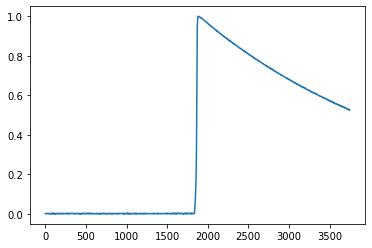

In [13]:
plt.plot(arr[0])

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
arr = scaler.fit_transform(arr)

In [15]:
train_data_length = arr.shape[0]
train_data = torch.zeros((train_data_length, 3748))
train_data = torch.tensor(arr, dtype=torch.float)
train_labels = torch.zeros(train_data_length, 1)

train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

In [16]:
batch_size = 128

In [17]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True
)

## 1. Models

In [18]:
#epochs = 500
lr = 1e-4
#autoenc
seq_len = 3748
emb_dim = seq_len // 16
#wgan
hidden_dim = 8
latent_dims = 32 


In [19]:
x = torch.randn(128, 3748)

In [20]:
class Encoder(nn.Module):   ## changed
    def __init__(self):
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        self.emb_dim = emb_dim
        self.model = nn.Sequential(            
            nn.Conv1d(self.seq_len, self.seq_len // 2, 1,  bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 2, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 4, self.seq_len // 8, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 8, self.emb_dim, 1, bias=False),
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        output = self.model(x)
        return output.squeeze(-1)

In [21]:
#x = torch.randn(1, 3748)
a = Encoder()
y = a(x)

In [22]:
y.shape

torch.Size([128, 234])

In [24]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.emb_dim = emb_dim
        self.model = nn.Sequential(
            nn.ConvTranspose1d(self.emb_dim, self.seq_len // 8, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 8),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 8, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 4, self.seq_len // 2, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 2),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 2, self.seq_len, 1, bias=False),
      )


    def forward(self, z):
        z = z.unsqueeze(-1)
        output = self.model(z)
        out = []
        for ibatch in range(output.size(0)):
            out.append(((output[ibatch] - output[ibatch].min()) / (output[ibatch].max() - output[ibatch].min())).unsqueeze(0))
        output = torch.cat(out, dim=0)       
        return output.squeeze(-1)

In [28]:
class Discriminator(nn.Module):   ## changed
    def __init__(self):
        super(Discriminator, self).__init__()
        self.emb_dim = emb_dim
        self.model = nn.Sequential(            
            nn.Conv1d(self.emb_dim, self.emb_dim // 2, 1,  bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.emb_dim // 2, self.emb_dim // 4, 1, bias=False),
            nn.BatchNorm1d(self.emb_dim // 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.emb_dim // 4, self.emb_dim // 8, 1, bias=False),
            nn.BatchNorm1d(self.emb_dim // 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.emb_dim // 8, 1, 1, bias=False),
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        output = self.model(x)
        return output.squeeze(-1)

In [51]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dims
        self.no_features = 1
        
        self.LSTM1 = nn.GRU(
            input_size = self.latent_dim,
            hidden_size = self.hidden_dim,
            num_layers = 1,
            batch_first = True
        )
        
        #self.fc1 = nn.Linear(self.hidden_dims * 4, self.hidden_dims)
        self.fc2 = nn.Linear(self.hidden_dim, self.no_features)


    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, self.emb_dim, 1)
        x, h0 = self.LSTM1(x)
        x = x.reshape((-1, self.emb_dim, self.hidden_dim))
        #x = self.fc1(x)
        x = self.fc2(x)
        output = torch.sigmoid(x)
        out = []
        for ibatch in range(output.size(0)):
            out.append(((output[ibatch] - output[ibatch].min()) / (output[ibatch].max() - output[ibatch].min())).unsqueeze(0))
        output = torch.cat(out, dim=0) 
        
        return output.squeeze()

In [52]:
a = torch.randn(128, 32)

In [53]:
g = Generator()

In [54]:
b = g(a)

In [57]:
b.shape

torch.Size([128, 234])

In [55]:
d = Decoder()

In [56]:
d(b).shape

torch.Size([128, 3748])

In [26]:
class PriorDiscriminator(nn.Module):
    def __init__(self,latent_dims=latent_dims):
        super().__init__()
        self.emb_dim = emb_dim
        self.l0 = nn.Linear(self.emb_dim, 64)
        self.l1 = nn.Linear(64, 64//4)
        self.l2 = nn.Linear(64//4, 1)
        
    def forward(self, x):
        h = F.leaky_relu(self.l0(x))
        h = F.leaky_relu(self.l1(h))
        return torch.sigmoid(self.l2(h))

In [27]:
a = Encoder()
y = a(x)
print(y.shape)
b = Decoder()
z = b(y)
print(z.shape)



torch.Size([128, 234])
torch.Size([128, 3748])


# Autoencoder

In [106]:
epochs_autoen = 500

In [107]:
encoder = Encoder().to(DEVICE)
decoder = Decoder().to(DEVICE)
disc = PriorDiscriminator().to(DEVICE)
recon_loss = nn.MSELoss(reduction = 'sum').to(DEVICE)

In [108]:
optim_encoder = torch.optim.Adam(encoder.parameters(), lr=1e-3)
optim_decoder = torch.optim.Adam(decoder.parameters(), lr=1e-3)

optim_encoder_reg = torch.optim.Adam(encoder.parameters(), lr=1e-3)
optim_D = torch.optim.Adam(disc.parameters(), lr=1e-3)

In [111]:
import torch.autograd as autograd
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_ep = []
losses = []
start_time = time.time()
EPS = 1e-15
one = torch.FloatTensor([1])
mone = one * -1
one = one.to(DEVICE)
mone = mone.to(DEVICE)
for epoch in range(epochs_autoen):
    for i, (x, y) in enumerate(train_loader):
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        batch = x.size(0)
        
        encoder.train()
        decoder.train()
        disc.train()
        
        encoder.zero_grad()
        decoder.zero_grad()
        disc.zero_grad()
        
        """ Reconstruction phase """
        z = encoder(x)
        x_hat = decoder(z)
        loss = recon_loss(x_hat,x)
        loss.backward()
        optim_encoder.step()
        optim_decoder.step()


        """ Discriminator phase """
        encoder.zero_grad()
        decoder.zero_grad()
        disc.zero_grad()
        encoder.eval()
        
        z_real_gauss = autograd.Variable(torch.randn(z.size())*1).to(DEVICE)
        z_fake_gauss = encoder(x)
        
        D_real_gauss, D_fake_gauss = disc(z_real_gauss), disc(z_fake_gauss.detach())
        
        real_outputs = D_real_gauss.mean(dim=0)
        real_outputs.backward(mone)
        fake_outputs = D_fake_gauss.mean(dim=0)
        fake_outputs.backward(one)
        optim_D.step()
        
        """ Regularization phase """
        encoder.zero_grad()
        decoder.zero_grad()
        disc.zero_grad()

        encoder.train()   # Back to use dropout
        z = encoder(x)
        D_fake_gauss = disc(z)
        fake_outputs = D_fake_gauss.mean(dim=0)
        fake_outputs.backward(mone)
        optim_encoder_reg.step()
        
        if epoch > 0 and i % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(x), len(data_loader_autoen.dataset),
                100. * i / len(data_loader_autoen), loss.item()))
            
        if (i == len(train_loader) - 1): # per epoch 
            loss_ep.append(loss.item())        
        
        losses.append(loss.item())        


    if epoch == 0:
        print("---1 epoch: %s seconds ---" % (time.time() - start_time))
    

torch.save(encoder.state_dict(), 'encoder.pth')
torch.save(decoder.state_dict(), 'decoder.pth')

---1 epoch: 1.5159471035003662 seconds ---


In [ ]:
fig = plt.figure()
plt.plot(losses, '.')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title("Autoencoder")
fig.savefig('Auto_losses.png')

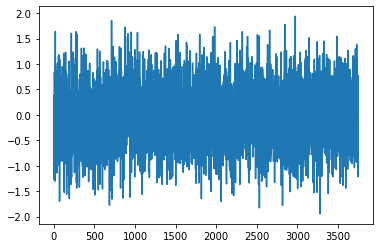

In [115]:
fixed_noise = torch.rand(128, emb_dim) 
with torch.no_grad(): #??
    fixed_noisev = fixed_noise.to(DEVICE)
plt.plot(decoder(fixed_noisev).detach()[0])

# WGAN

In [116]:
netD = Discriminator().to(DEVICE)
netG = Generator().to(DEVICE)

In [122]:
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr)
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr)
loss_G=[]
loss_D=[]
epochs = []

G_losses = []
D_losses = []

one = torch.tensor(1, dtype=torch.float)
mone = one * -1
one = one.to(DEVICE)
mone = mone.to(DEVICE)

ITERS = 1
CRITIC_ITERS = 5

In [123]:
minim_G = 10**9
maxim_D = -10**9  # these values are used to find the epoch, where G_loss is the least.

n_critic = 5

def inf_train_gen():
    while True:
        for images,targets in train_loader:
            yield images

In [124]:
LAMBDA = 10

def calc_gradient_penalty(netD, real_data, fake_data):
    #print real_data.size()
    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(DEVICE)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    interpolates = interpolates.to(DEVICE)
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(DEVICE),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

In [132]:
random_dim = latent_dims
netD = netD.to(DEVICE)
netG = netG.to(DEVICE)
data = inf_train_gen()
for iteration in range(ITERS):
    epochs.append(iteration)
    start_time = time.time()
    ############################
    # (1) Update D network
    ###########################
    for p in netD.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update

    for iter_d in range(CRITIC_ITERS):
        _data = next(data)
        _data = encoder(_data).detach()
        real_data = torch.Tensor(_data)
        real_data = real_data.to(DEVICE)
        real_data_v = autograd.Variable(real_data).to(DEVICE)

        netD.zero_grad()

        # train with real
        D_real = netD(real_data_v)
        D_real = D_real.mean()
        # print D_real
        D_real.backward(mone)

        # train with fake
        noise = torch.randn(batch_size, random_dim).to(DEVICE)
        fake = netG(noise).detach()
        inputv = fake
        D_fake = netD(inputv)
        D_fake = D_fake.mean()
        D_fake.backward(one)

        # train with gradient penalty
        gradient_penalty = calc_gradient_penalty(netD, real_data_v.data, fake.data)
        gradient_penalty.backward()

        D_cost = D_fake - D_real + gradient_penalty
        Wasserstein_D = D_real - D_fake
        optimizerD.step()
        
    loss_D.append(D_cost.item())

    ############################
    # (2) Update G network
    ###########################
    for p in netD.parameters():
        p.requires_grad = False  # to avoid computation
    netG.zero_grad()

    _data = next(data)
    noise = torch.randn(batch_size, random_dim).to(DEVICE)
    noisev = autograd.Variable(noise).to(DEVICE)
    fake = netG(noisev)
    G = netD(fake)
    G = G.mean()
    G.backward(mone)
    G_cost = -G
    loss_G.append(G_cost.item())
    optimizerG.step()
    if iteration % 10 == 0:
        torch.save(netG.state_dict(), 'checkpoint'+str(iteration)+'.pth')

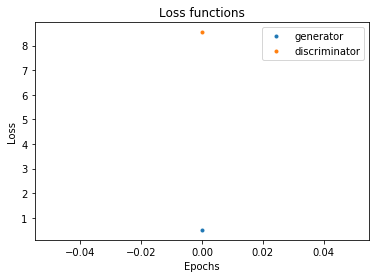

In [126]:
fig = plt.figure()
plt.plot(epochs, loss_G, '.', label='generator')
plt.plot(epochs, loss_D, '.',  label='discriminator')
plt.title('Loss functions')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
fig.savefig('losses.png')

In [ ]:
torch.save(netG.state_dict(), 'generator.pth')

In [128]:
x = torch.randn(10, 32)

In [129]:
noise = netG(x)

In [130]:
decoder(noise)

tensor([[-0.8057,  0.0521, -0.3463,  ...,  1.1170,  0.6827,  0.0885],
        [-0.1104,  0.0687,  0.1404,  ...,  0.3693,  0.3477, -0.2538],
        [ 0.2108, -0.2604, -0.2717,  ...,  0.3214,  0.3538, -0.0506],
        ...,
        [-0.0580, -0.0272, -0.4523,  ...,  0.2416,  0.5828,  0.1513],
        [ 0.1124, -0.4011, -0.4934,  ..., -0.0931,  0.6101, -0.2126],
        [-0.3462, -0.1607,  0.1190,  ...,  0.7075,  0.5755,  0.0836]],
       grad_fn=<SqueezeBackward1>)

In [ ]:
############